In [1]:
import numpy as np
import scipy
import pandas as pd
import torch
from datetime import datetime, timedelta
from scipy.stats import qmc
from bo_methods_lib.bo_functions_generic import round_time, gen_theta_set,gen_x_set, find_train_doc_path, set_ep, clean_1D_arrays
from bo_methods_lib.GP_Vs_True_Sensitivity import Muller_plotter
from bo_methods_lib.GP_Vs_True_Param_Sens import mul_plot_param
# from .CS1_create_data import gen_y_Theta_GP, calc_y_exp, create_y_data
from bo_methods_lib.CS2_create_data import gen_y_Theta_GP, calc_y_exp, create_y_data

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Section 1) Setting Parameters/ Defining the Problem

In [2]:
#Set Parameters

CS = 2.2 #Case Study
DateTime = None #Date and Time

Bound_Cut = True #Defines whether original bounds are cut
eval_Train = True #Defines whether we are examining close to the true parameter set or the first training parameter set

#Consatnts for the Muller Potential
Constants = np.array([[-200,-100,-170,15],
                      [-1,-1,-6.5,0.7],
                      [0,0,11,0.6],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]])

#Case Study 2.2 defined as the 8 parameter Muller potential
if CS == 2.2:
    skip_param_types = 1 #This is what changes for subpoint
    true_p = Constants[skip_param_types:skip_param_types+2].flatten()
    param_dict = {0 : 'a_1', 1 : 'a_2', 2 : 'a_3', 3 : 'a_4',
                  4 : 'b_1', 5 : 'b_2', 6 : 'b_3', 7 : 'b_4'}
    exp_d = 2 #Dimensioanlity of X data
    if Bound_Cut == True:
        bounds_x = np.array([[-1.0, 0.0], #Bounds on X space (after cutting)
                            [   0.5, 1.5]])
        n = 25 #Number of experimental data points to use
    else:    
        bounds_x = np.array([[-1.5, -0.5],  #Uncut bounds on X space
                     [   1,    2]])
        n = 27 #Number of experimental data points to use
    bounds_p = np.array([[-2, -2, -10, -2, -2, -2,  5, -2], #Bounds on parameter space
                   [ 2,  2,   0,  2,  2,  2, 15,  2]])
    minima = np.array([[-0.558,1.442], #Minima of true Muller potential
                              [-0.050,0.467],
                              [0.623,0.028]])

    saddle = np.array([[-0.82,0.62], #Saddle points of True Muller potential
                              [0.22,0.30]])

#Case Study 1 is the cubic equation toy problem
else:
    Constants = true_p = np.array([1,-1])
    skip_param_types = 0
    param_dict = {0 : '\\theta_1', 1 : '\\theta_2'}
    exp_d = 1
    n = 5
    bounds_x = np.array([[-2], [2]])
    bounds_p = np.array([[-2, -2],
                         [ 2,  2]])

package = "scikit_learn" #Package training the GP model
t = 20 #Number of parameter training sets
# percentiles = np.linspace(-1.0,1.0,41)
percentiles = np.linspace(0,0,1) #Percent by which to deviate from a given parameter set
value_num = 100 #Number of parameter values for each parameter to evaluate within the bounds
d = len(true_p) #Dimensionality of parameter space
kernel_func = "Mat_52" #Kernel function to use
train_iter = 300 #Maximum GP training iterations
initialize = 2 #Number of times to restart GP training
noise_std = 0.1 #Noise assocuated with data
set_lenscl = None #lengthscale of the kernel (None means it will be optimized)
verbose = False
rand_seed = False #Whether or not a random seed it used for RNG events

emulator = True #GP directly emulates function
obj = "obj"

save_figure = True #Whether to save figures
# save_figure = False
save_csvs = True #Whether to save CSVs
# save_csvs = False

#Naming convention to pull experimental and training data from CSVs
if Bound_Cut == True:
    cut_bounds = '_cut_bounds'
else:
    cut_bounds = ""

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/d='+str(exp_d)+'/n='+str(n)+cut_bounds+'.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1:exp_d+1]
Yexp = exp_data[:,-1]
Xexp = clean_1D_arrays(Xexp)
m = Xexp.shape[1]

#Pull training data from CSV
t_use = int(t*n)
all_data_doc = find_train_doc_path(emulator, obj, d, t_use, bound_cut = Bound_Cut)
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))
X_train = torch.tensor(all_data[:,1:-m+1]).float() #8 or 10 (emulator) parameters
Y_train = train_y = torch.tensor(all_data[:,-1]).float()

In [3]:
#Set meshgrid values and define a meshgrid over X_space
p = 20
X1 =  np.linspace(bounds_x[0,0],bounds_x[1,0],p) 
X2 =  np.linspace(bounds_x[0,1],bounds_x[1,1],p) 
X_mesh = np.array(np.meshgrid(X1, X2)) 
#Generate the same points as X_mesh in a 2D array
X_space = gen_x_set(LHS = False, n_points = p, dimensions = exp_d, bounds = bounds_x) 

# Section 2) Building/ Training the Model

In [4]:
def train_GP_scikit(train_param, train_data, noise_std, kern = "Mat_52", verbose=False, 
                    set_lenscl = None, initialize = 1, rand_seed = False):
    """
    Trains the GP model and finds hyperparameters with the scikit learn package
    
    Parameters
    ----------
        train_param: tensor or ndarray, The training parameter space data
        train_data: tensor or ndarray, The training y data
        iterations: float or int, number of training iterations to run. Default is 300
        verbose: Set verbose to "True" to view the associated loss and hyperparameters for each training iteration. False by default
        set_lenscl: float/None: Determines whether Hyperparameter values will be set. None by Default
    
    Returns
    -------
        lenscl_final: ndarray, List containing value of the lengthscale hyperparameter at the end of training
    """
    if rand_seed == False:
        random_state = 1
    else:
        random_state = None

    if kern == "RBF":
        kernel = RBF(length_scale_bounds=(1e-2, 1e2)) # RBF
    elif kern == "Mat_32":
        kernel = Matern(length_scale_bounds=(1e-05, 10000000.0), nu=1.5) #Matern 3/2
    else:
        kernel = Matern(length_scale_bounds=(1e-05, 10000000.0), nu=2.5) #Matern 5/2

    if set_lenscl != None:
        lengthscale_val = np.ones(train_param.shape[1])*set_lenscl
        kernel.length_scale_bounds = "fixed"
        optimizer = None
    else:
        lengthscale_val = np.ones(train_param.shape[1])
        optimizer = "fmin_l_bfgs_b"

    kernel.length_scale = lengthscale_val
#     print("Original lengthscale: ", kernel.length_scale)
    gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=initialize, 
                                                random_state = random_state, optimizer = optimizer)
    #Train GP
    gaussian_process.fit(train_param, train_data)

    # print("gaussian_process.get_params()['kernel__length_scale']: ", 
    #       gaussian_process.get_params()['kernel__length_scale'])
    # print("kernel.theta: ", kernel.theta ) #
    # print("kernel.length_scale: ", kernel.length_scale )

    #Print lengthscale values
    if set_lenscl != None:
        lenscl_final = kernel.length_scale
    else:
        lenscl_final = kernel.theta #Value after training, but doesn't show values if they weren't optimized. How to show all?

    if verbose == True:
        if set_lenscl is not None:
            print("Lengthscale Set To: " + str(np.round(np.array(lenscl_final),4)), "\n")
        else:
            print("Lengthscale is optimized using MLE to " + str(np.round(np.array(lenscl_final),4)), "\n" ) 
            
    return lenscl_final, gaussian_process

In [5]:
lenscl_final, gaussian_process = train_GP_scikit(X_train, Y_train, noise_std, kernel_func, verbose, None, 
                                                 initialize, rand_seed = False)   
print("Final Lengthscale: ", lenscl_final)

Final Lengthscale:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 10000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 10000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 10000000.0. Increasing the bound and calling fi

# Section 3: Comparing GP and Y Sim Predictions on a Heat Map

In [6]:
def eval_GP_scipy(theta_set, X_space, true_model_coefficients, model, skip_param_types=0, CS=1, Xspace_is_Xexp = False):
    """ 
    Calculates the expected improvement of the emulator approach
    Parameters
    ----------
        theta_set: ndarray (num_LHS_points x dimensions), list of theta combinations
        X_space: ndarray, The points for X over which to evaluate the GP (p^2 x dim(x) or n x dim(x))
        true_model_coefficients: ndarray, The array containing the true values of problem constants
        model: bound method, The model that the GP is bound by (gpytorch ot scikitlearn method)
        likelihood: bound method, The likelihood of the GP model. In this case, must be a Gaussian likelihood or None
        skip_param_types: The offset of which parameter types (A - y0) that are being guessed. Default 0
        CS: float, the number of the case study to be evaluated. Default is 1, other option is 2.2 
        Xspace_is_Xexp: bool, whether X_space is is a set of meshgrid values or Xexp values
    
    Returns
    -------
        GP_mean: ndaarray, Array of GP mean predictions at X_space and theta_set
        GP_stdev: ndarray, Array of GP variances related to GP means at X_space and theta_set
        y_sim: ndarray, simulated values at X_space and theta_set
    """
    #Define dimensionality of X 
    X_space = clean_1D_arrays(X_space, True)
    m = X_space.shape[1]
    p_sq = X_space.shape[0]
    p = int(np.sqrt(p_sq))
    
    #Set theta_set to only be parameter values
    theta_set_params = theta_set
    
    #Define the length of theta_set and the number of parameters that will be regressed (q)
    if len(theta_set_params.shape) > 1:
        len_set, q = theta_set_params.shape[0], theta_set_params.shape[1]
    else:
        theta_set_params = clean_1D_arrays(theta_set_params, param_clean = True)
        len_set, q = theta_set_params.shape[0], theta_set_params.shape[1]
    
    #Initialize values for saving data
    GP_mean = np.zeros((p_sq))
    GP_var = np.zeros((p_sq))
    y_sim = np.zeros((p_sq))
    
    #Loop over experimental data 
    for k in range(p_sq):
        ##Calculate Values
        #Define a parameter set, point
        point = list(theta_set_params[0])
        #Append Xexp_k to theta_set to evaluate at theta, xexp_k
        x_point_data = list(X_space[k]) #astype(np.float)
        #Create point to be evaluated
        point = point + x_point_data
        eval_point = torch.from_numpy(np.array([point])).float()
        #Evaluate GP given parameter set theta and state point value
        model_mean, model_variance = model.predict(eval_point, return_std=True)
        
        #Save values of GP mean and variance
        GP_mean[k] = model_mean
        GP_var[k] = model_variance
        
        #Calculate y_sim
        if CS == 1:
            #Case study 1, the 2D problem takes different arguments for its function create_y_data than 2.2
            y_sim[k] = create_y_data(eval_point)
        else:
            y_sim[k] = create_y_data(eval_point, true_model_coefficients, X_space, skip_param_types)
    
    #Define GP standard deviation   
    GP_stdev = np.sqrt(GP_var)  
        
    if m > 1 and Xspace_is_Xexp == False:
        #Turn GP_mean, GP_stdev, and y_sim back into meshgrid form
        GP_stdev = np.array(GP_stdev).reshape((p, p))
        GP_mean = np.array(GP_mean).reshape((p, p))
        y_sim = np.array(y_sim).reshape((p, p))
   
    return GP_mean, GP_stdev, y_sim

#Set parameter set to evaluate at
if eval_Train == False:
    eval_p_base = true_p #True parameter set
else:
    eval_p_base = X_train[0,:-exp_d] #Parameter set corresponding to first training point
print("Evaluation Parameter Set", eval_p_base)

Evaluation Parameter Set tensor([-1.1740, -1.6574, -9.8016, -1.5555,  0.6568,  0.0169, 14.5698, -0.1836])


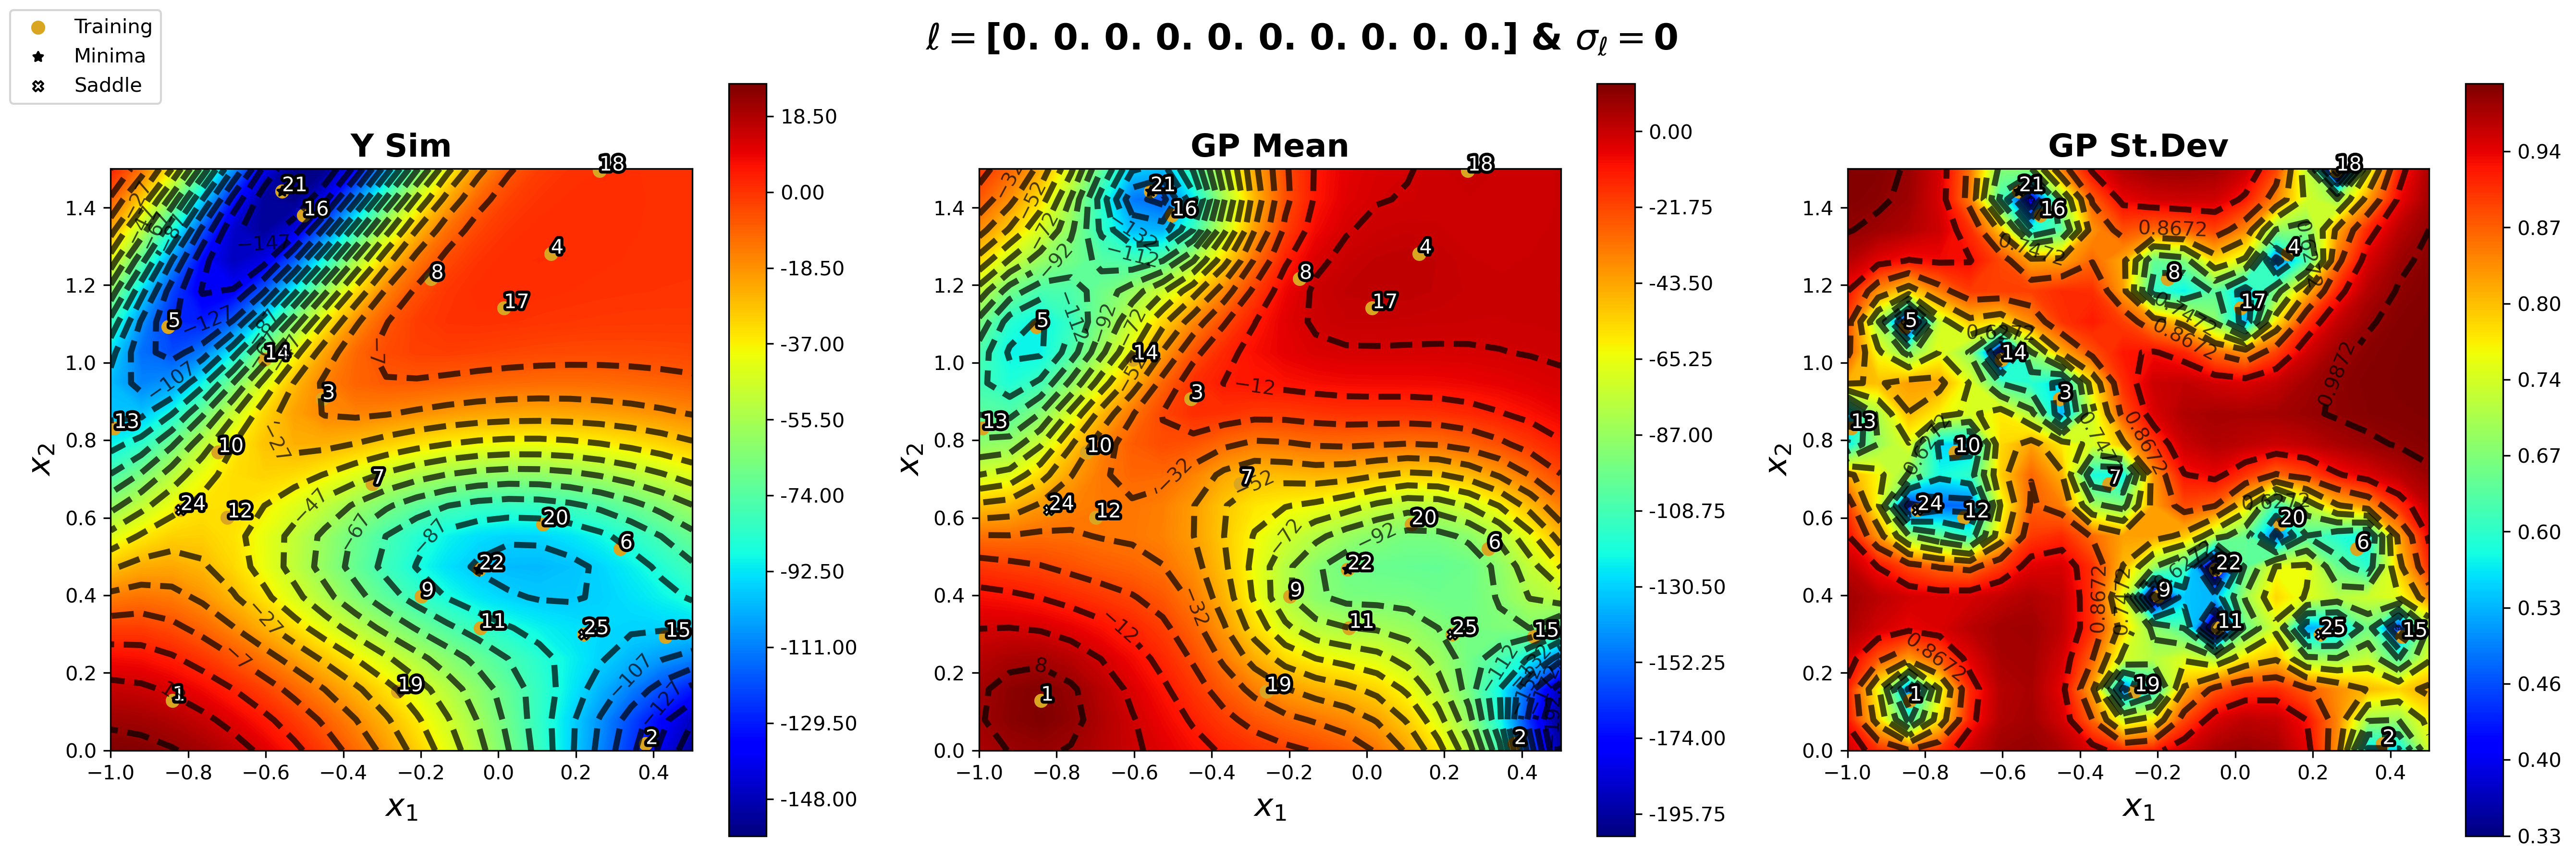

In [7]:
#Evaluate GP for true parameter set value over all of X parameter space
GP_mean, GP_stdev, y_sim = eval_GP_scipy(eval_p_base, X_space, Constants, gaussian_process, skip_param_types, CS, False)

#Plot GP Predictions and True value
title = ["Y Sim", "GP Mean", "GP St.Dev"]
z = [y_sim.T, GP_mean.T, GP_stdev.T]
#Not sure how to find stdev of the lengthscale
#Note: Pulled this plotting code from file bo_methods_lib/GP_Vs_True_Sensitivity.py
Muller_plotter(X_mesh, z, minima, saddle, title, set_lenscl, train_iter, t, CS, Bound_Cut, 
               lenscl_final = lenscl_final, lenscl_noise_final = 0, kernel = "Mat 5/2", DateTime = None, X_train = Xexp, 
               save_csvs = False, save_figure = False, Mul_title = "", param = "", percentile = "", 
               tot_lev = [40,40,75])

# Section 4: Predictions Over Theta

In [8]:
#Define X_space points to test for predictions
x_set_points = [1,6,12,17,20]
X_set= np.array([Xexp[m] for m in x_set_points])
Xspace_is_Xexp = False

def Compare_GP_True_Param_Sens(eval_p_base, X_set, value_num, bounds_p, Constants, model, 
                               skip_param_types, CS, Xspace_is_Xexp):
    #Make eval point base a tensor
    if torch.is_tensor(eval_p_base) == False:
        eval_p_base = torch.tensor(eval_p_base)
    q = len(eval_p_base)
    #Create list to save evaluated arrays in and arrays to store GP mean/stdev and true predictions in
    GP_mean_all = np.zeros((len(X_set), q, value_num) )
    GP_stdev_all = np.zeros((len(X_set), q, value_num) )
    y_sim_all = np.zeros((len(X_set), q, value_num) )

    #Create list to save evaluated parameter sets and values in
    eval_p_df = []
    values_list = [] 

    ##Evaluate parameter sets at each Xspace value
    #Loop over all parameters
    for i in range(len(eval_p_base)):   
        #Clone the base value
        eval_p = eval_p_base.clone()
        #Define upper and lower theta bounds
        lower_theta = bounds_p[0,i]
        upper_theta = bounds_p[1,i]
        #Define Values to test
        values = np.linspace(lower_theta, upper_theta, value_num) #Note: Default to 41 
        values_list.append(values)
        #Save each bound value as a number from 0 to len(percentiles)
        val_num_map = np.linspace(0,len(values)-1, len(values))
        #Define parameter sets to test   
        for j in range(len(values)):   
            # Evaluate at the original point for each parameter and swap a parameter value for a value within the bounds
            new_eval_p = values[j]
            #Change the value to the exact point except for 1 variable that is rounded to 2 sig figs after modification by a percent
            eval_p[i] = torch.tensor(float('%.2g' % float(new_eval_p)))
            #Append evaluated value to this list only on 1st iteration of k
            eval_p_df.append(list(eval_p.numpy()))
            #Loop over Xspace Values: #Note. X_space defined as Xexp points we want to test
            for k in range(len(X_set)):
                #Evaluate the values
                eval_components_Xset = eval_GP_scipy(eval_p, X_set[k], Constants, model, skip_param_types, 
                                                     CS, Xspace_is_Xexp = False)
                #Get GP predictions and true values
                GP_mean_Xset, GP_stdev_Xset, y_sim_Xset = eval_components_Xset
                #Append GP mean, GP_stdev, and true values to arrays outside of loop
                GP_mean_all[k,i,j], GP_stdev_all[k,i,j], y_sim_all[k,i,j] = GP_mean_Xset, GP_stdev_Xset, y_sim_Xset

    return y_sim_all, GP_mean_all, GP_stdev_all, values_list, val_num_map

Evals  = Compare_GP_True_Param_Sens(eval_p_base, X_set, value_num, bounds_p, Constants, gaussian_process, 
                                    skip_param_types, CS, Xspace_is_Xexp)

y_sim_all, GP_mean_all, GP_stdev_all, values_list, val_num_map = Evals

In [9]:
#Plot GP vs y_sim predictions for each Xexp Value and save data
all_data_to_plot = [y_sim_all, GP_mean_all, GP_stdev_all] 
#Note: Plotting function pulled from
mul_plot_param(all_data_to_plot, set_lenscl, train_iter, t, CS, Bound_Cut, X_set, x_set_points, 
               param_dict, values_list, val_num_map, lenscl_final, "", kernel_func, DateTime, Xexp, save_csvs, 
               save_figure, package)

# Section 5: Manual Lengthscale Sensitivity Analysis

In [10]:
lengthscales = [0.1, 1, 10, 100, 1e3, 1e4, None]

for lenscl in lengthscales:
    lenscl_final, gaussian_process = train_GP_scikit(X_train, Y_train, noise_std, kernel_func, verbose, lenscl, 
                                                     initialize, rand_seed = False)  
    #Evaluate GP for true parameter set value over all of X parameter space
    Evals  = Compare_GP_True_Param_Sens(eval_p_base, X_set, value_num, bounds_p, Constants, gaussian_process, 
                                    skip_param_types, CS, Xspace_is_Xexp)

    y_sim_all, GP_mean_all, GP_stdev_all, values_list, val_num_map = Evals
    
    #Plot GP vs y_sim predictions for each Xexp Value and save data
    all_data_to_plot = [y_sim_all, GP_mean_all, GP_stdev_all] 

    mul_plot_param(all_data_to_plot, lenscl, train_iter, t, CS, Bound_Cut, X_set, x_set_points, 
                   param_dict, values_list, val_num_map, lenscl_final, "", kernel_func, DateTime, Xexp, save_csvs, 
                   save_figure, package)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 10000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 10000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 10000000.0. Increasing the bound and calling fi

# Section 6: Dense Grid x1 and x2 + LHS Parameters